<a href="https://colab.research.google.com/github/HJoonKwon/ml_fundamentals/blob/main/BinaryLogisticRegressionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary Logistic Regression 
- Supervised learning algorithm 
- Discriminative classifier
- Use an activation function called logistic function or sigmod function 
- Minimize binary cross engropy loss 
  - There is no closed-form solution
  - So, we should use gradient descent to find an optimal solution.

## How does it work? 
- The network will predict the probability of the output being positive. 
- The output of the network looks like below:
$$ z = (\sum_{i=1}^n w_i x_i) + b$$
$$ ŷ = sigmoid(z) = \frac{1}{1+e^{-z}}$$
- The output ```y```, the probability of being positive, always falls into ```[0, 1]```
- The update equation based on gradient descent is:
$$ \theta := \theta - η∇L(ŷ, y)$$
- ```L``` is the binary cross-entropy loss which can be defined as:
$$ L_{CE}(ŷ,y) = -\frac{1}{m} \sum_{i=1}^m [ylog(ŷ) + (1-y)log(1-ŷ)]$$
- The partial derivatives of ```L``` with respect to ```w``` and ```b``` are:
$$ \frac{∂L_{CE}(ŷ, y)}{∂w} = \frac{1}{m}(ŷ-y)x_i^T$$
$$ \frac{∂L_{CE}(ŷ, y)}{∂b} = \frac{1}{m}(ŷ-y)1^T$$ 


## Newton's Method
$$ \theta := \theta - H^{-1}\nabla_{\theta}J(\theta) $$
$$ H_{ij} =  \frac{\partial^2 J(\theta)}{\partial \theta_i \partial \theta_j}$$
## Stable sigmoid trick 
- The original sigmoid function becomes numerically unstable when ```z``` is a very small negative number. (Overflow)
- This problem can be solved using the trick below:
  - if ```z >= 0```
$$ sigmod(z) = \frac{1}{1+e^{-z}}$$ 
  - if ```z < 0```
$$ sigmoid(z) = \frac{e^z}{1+e^z}$$
- Both of the equations are mathematically the same, so it will not change the value of the output.

In [9]:
import numpy as np 
import math 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from ml_algorithms.logistic_regression import *

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(42)

## 1) Prepare for dataset 
- We are going to use Breast [Breast cancer wisconsin (diagnostic) dataset text](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset)
- Load, normalize, and split the dataset 

In [2]:
def normalize(data: np.ndarray):
    data = (data-np.mean(data, axis=0))/np.std(data, axis=0)
    return data 

In [65]:
dataset = load_breast_cancer() 
X = dataset['data']
y = dataset['target']
target_names = dataset['target_names']
feature_names = dataset['feature_names']
print(f'feature_names: {feature_names}')
print(f'target_names: {target_names}')

feature_names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
target_names: ['malignant' 'benign']


In [66]:
X = normalize(X)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X = train_X.T
train_y = train_y.reshape(1, -1)
test_X = test_X.T 
test_y = test_y.reshape(1, -1)
print(f'train_X: {train_X.shape}')
print(f'train_y: {train_y.shape}')
print(f'test_X: {test_X.shape}')
print(f'test_y: {test_y.shape}')

train_X: (30, 455)
train_y: (1, 455)
test_X: (30, 114)
test_y: (1, 114)


## 2) Implement Logistic Regression 

In [48]:
import inspect
lines = inspect.getsource(LogisticRegression)
print(lines)

class LogisticRegression():
    def __init__(self):
        self.train_X: np.ndarray
        self.train_Y: np.ndarray
        self.W: np.ndarray
        self.b: np.ndarray

    def fit(self, X: np.ndarray, Y: np.ndarray, learning_rate: float,
            iterations: int):

        self.train_X = X
        self.train_Y = Y
        self.W = np.zeros((self.train_Y.shape[0], self.train_X.shape[0]))
        self.b = np.zeros((self.train_Y.shape[0], 1))

        costs = []
        for iter in range(iterations):
            Z = self.linear_forward(self.train_X)
            Y_hat = self.sigmoid(Z)
            cost = self.cost(Y_hat, self.train_Y)
            gradients = self.gradients(Y_hat)
            self.update_parameters(gradients, learning_rate)
            costs.append(cost)
            if iter % 50 == 0 and iter != 0:
                print(f"cost @ iter{iter}= {cost}")

        return costs

    def predict(self, X: np.ndarray) -> np.ndarray:
        Z = self.linear_forward(X)
        

## 3) Test the algorithm

In [45]:
learning_rate = 0.1
iterations = 500

In [46]:
model = LogisticRegression()
costs = model.fit(train_X, train_y, learning_rate=learning_rate, iterations=iterations)

cost @ iter50= 0.13258488785653577
cost @ iter100= 0.10573618627582446
cost @ iter150= 0.0939552345469794
cost @ iter200= 0.08695358036356038
cost @ iter250= 0.08217260393814141
cost @ iter300= 0.07863132509383393
cost @ iter350= 0.0758636582347195
cost @ iter400= 0.07361682746896966
cost @ iter450= 0.07174063697889288


In [64]:
preds = model.predict(test_X)
accuracy = np.sum(preds==test_y)/preds.shape[1]
print(f'accuracy on testset is {accuracy}')

accuracy on testset is 0.9824561403508771


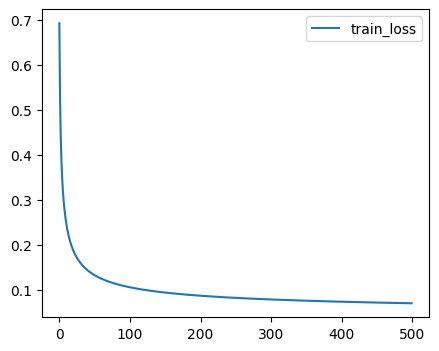

In [63]:
import matplotlib.pyplot as plt

plt.figure() 
plt.plot(range(iterations), costs, label='train_loss')
plt.legend()

## References 
- https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/
- https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
- https://web.stanford.edu/~jurafsky/slp3/5.pdf